In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.neuop import *
from ipynb.fs.full.lploss import *
import torch
import os
import copy, random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

In [2]:
today = datetime.now().strftime("%m%d%Y")
today, os.getcwd() 

('07062024', '/scratch/user/daniel_88/twophase_ufno/abs/abs_dsw/forgithub')

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device, torch.cuda.get_device_name(device=device)

('cuda', 'NVIDIA A100-PCIE-40GB')

In [4]:
kPa = 1e3
MPa = 1e6
psi = 6895
p0 = 30*MPa
mD = 9.869233e-16
m3_day = 1/86400

In [5]:
# import training/validation data:
with open("./CMG_TP_40x40x366_dt05_TrainVal_4000_280x280x5_2.npy", 'rb') as f:
    inp_data_original = np.load(f)
    outp_data_original = np.load(f)

inp_data_original.shape, outp_data_original.shape

((4000, 40, 40, 366, 7), (4000, 40, 40, 366, 2))

In [6]:
# import testing data:
with open("./CMG_TP_40x40x366_dt05_Test_200_280x280x5.npy", 'rb') as f:

    test_a_original = np.load(f)
    test_u_original = np.load(f)

test_a_original.shape, test_u_original.shape

((200, 40, 40, 366, 7), (200, 40, 40, 366, 2))

In [7]:
np.random.seed(0)

ntr = 3500
nval = 500
nts = 200

nt = 40
tsplit = 240 # training time range [0,tsplit], validation & testing time range [tsplit,:]

train_a = np.zeros_like(inp_data_original[:ntr,...,:nt,:])
train_u = np.zeros_like(outp_data_original[:ntr,...,:nt,:])

val_a = np.zeros_like(inp_data_original[:nval,...,:nt,:])
val_u = np.zeros_like(outp_data_original[:nval,...,:nt,:])

test_a = np.zeros_like(test_a_original[:nts,...,:nt,:])
test_u = np.zeros_like(test_u_original[:nts,...,:nt,:])

# pick random number up to 100:
tr_indices = np.random.randint(0, tsplit-nt, size=(ntr,))
tr_indices[:floor(0.1*ntr)] = 0
tr_indices = np.sort(tr_indices) # for visualization error purposes only

vl_indices = np.random.randint(0, inp_data_original.shape[3]-nt, size=(nval,))
vl_indices[:floor(0.1*nval)] = 0
vl_indices = np.sort(vl_indices) # for visualization error purposes only

ts_indices = np.random.randint(0, test_a_original.shape[3]-nt, size=(nts,))
ts_indices[:floor(0.1*nts)] = 0
ts_indices = np.sort(ts_indices) # for visualization error purposes only

for i in range(ntr):
    train_a[i] = inp_data_original[i, ..., tr_indices[i]:tr_indices[i]+nt, : ]
    train_u[i] = outp_data_original[i, ..., tr_indices[i]:tr_indices[i]+nt, : ]

for i in range(nval):
    val_a[i] = inp_data_original[inp_data_original.shape[0]-nval+i, ..., vl_indices[i]:vl_indices[i]+nt, : ]
    val_u[i] = outp_data_original[inp_data_original.shape[0]-nval+i, ..., vl_indices[i]:vl_indices[i]+nt, : ]

for i in range(nts):
    test_a[i] = test_a_original[i, ..., ts_indices[i]:ts_indices[i]+nt, : ]
    test_u[i] = test_u_original[i, ..., ts_indices[i]:ts_indices[i]+nt, : ]

train_a.shape, train_u.shape, val_a.shape, val_u.shape, test_a.shape, test_u.shape

((3500, 40, 40, 40, 7),
 (3500, 40, 40, 40, 2),
 (500, 40, 40, 40, 7),
 (500, 40, 40, 40, 2),
 (200, 40, 40, 40, 7),
 (200, 40, 40, 40, 2))

In [8]:
# append initial condition channel to inputs:

i_pres = train_u[..., 0:1, 0]
i_sw = train_u[..., 0:1, 1]
train_a = np.insert(train_a, 4, i_pres, axis=-1)
train_a = np.insert(train_a, 5, i_sw, axis=-1)

i_pres = val_u[..., 0:1, 0]
i_sw = val_u[..., 0:1, 1]
val_a = np.insert(val_a, 4, i_pres, axis=-1)
val_a = np.insert(val_a, 5, i_sw, axis=-1)

i_pres = test_u[..., 0:1, 0]
i_sw = test_u[..., 0:1, 1]
test_a = np.insert(test_a, 4, i_pres, axis=-1)
test_a = np.insert(test_a, 5, i_sw, axis=-1)

train_a.shape, val_a.shape, test_a.shape

((3500, 40, 40, 40, 9), (500, 40, 40, 40, 9), (200, 40, 40, 40, 9))

In [9]:
max_time = np.max(train_a[...,-1])

max_time

2380.0

In [10]:
kmax = np.max(train_a[...,0])
kmin = np.min(train_a[...,0])

# maximum and minimum pressures taken from producer controls
pmin = np.min(train_a[..., 1][train_a[..., 1].nonzero()])
pmax = np.max(train_u[..., 0])

# maximum and minimum rates taken from injector controls
qmin = np.min(train_a[..., 2][train_a[..., 2].nonzero()])
qmax = np.max(train_a[..., 2])

kmin/mD, kmax/mD, pmin, pmax, qmin, qmax

(0.004683786989063543, 406.4115250090385, 5000.2, 171539.0, 0.2, 2.5)

In [11]:
# normalize permeability
train_a[..., 0] = np.log10(train_a[..., 0]/kmin) / np.log10(kmax/kmin)
val_a[..., 0] = np.log10(val_a[..., 0]/kmin) / np.log10(kmax/kmin)
test_a[..., 0] = np.log10(test_a[..., 0]/kmin) / np.log10(kmax/kmin)

train_a.shape, val_a.shape, test_a.shape

((3500, 40, 40, 40, 9), (500, 40, 40, 40, 9), (200, 40, 40, 40, 9))

In [12]:
import platform
platform.system()

'Linux'

In [13]:
# normalize pressures
# ---------------------

# normalize well controls (pressures and rates)
train_a[..., 1] = train_a[..., 1] / pmax
val_a[..., 1] = val_a[..., 1] / pmax
test_a[..., 1] = test_a[..., 1] / pmax

train_a[..., 2] = train_a[..., 2] / qmax
val_a[..., 2] = val_a[..., 2] / qmax
test_a[..., 2] = test_a[..., 2] / qmax


# normalize initial condition. initial saturations are already normalized by definition
train_a[...,4] = train_a[..., 4] / pmax
val_a[...,4] = val_a[..., 4] / pmax
test_a[...,4] = test_a[..., 4] / pmax


# normalize output pressure. saturations are already normalized by definition
train_u[..., 0] = train_u[...,0] / pmax
val_u[..., 0] = val_u[...,0] / pmax
test_u[..., 0] = test_u[...,0] / pmax

In [14]:
# normalize space

# X
xmin, xmax = train_a[0,0,0,0,-3], train_a[0,-1,0,0,-3]
train_a[..., -3] = (train_a[..., -3] - xmin) / (xmax-xmin)
val_a[..., -3] = (val_a[..., -3] - xmin) / (xmax-xmin)
test_a[..., -3] = (test_a[..., -3] - xmin) / (xmax-xmin)

# Y
ymin, ymax = train_a[0,0,0,0,-2], train_a[0,0,-1,0,-2]
train_a[..., -2] = (train_a[..., -2] - ymin) / (ymax-ymin)
val_a[..., -2] = (val_a[..., -2] - ymin) / (ymax-ymin)
test_a[..., -2] = (test_a[..., -2] - ymin) / (ymax-ymin)

# T
train_a[..., -1] = train_a[..., -1] / max_time
val_a[..., -1] = val_a[..., -1] / max_time
test_a[..., -1] = test_a[..., -1] / max_time

In [15]:
nx = train_a.shape[1]
ny = train_a.shape[2]
nt = train_a.shape[3]

#--------------------------------------------------------------------------
# add augmentation to increase training samples
# for testing, no need for augmentation

augment = False

if augment:
    train_a_flipud = np.flip(train_a, axis=1)
    train_a_fliplr = np.flip(train_a, axis=2)
    train_a_flipdiag = np.flip(train_a_fliplr, axis=1)

    train_u_flipud = np.flip(train_u, axis=1)
    train_u_fliplr = np.flip(train_u, axis=2)
    train_u_flipdiag = np.flip(train_u_fliplr, axis=1)

    train_a = np.concatenate([train_a, train_a_flipud, train_a_fliplr, train_a_flipdiag], axis=0)
    train_u = np.concatenate([train_u, train_u_flipud, train_u_fliplr, train_u_flipdiag], axis=0)
    
    ntr = 4*ntr
    
train_a.shape, train_u.shape, val_a.shape, val_u.shape, test_a.shape, test_u.shape

((3500, 40, 40, 40, 9),
 (3500, 40, 40, 40, 2),
 (500, 40, 40, 40, 9),
 (500, 40, 40, 40, 2),
 (200, 40, 40, 40, 9),
 (200, 40, 40, 40, 2))

In [16]:
# convert to torch tensors

train_a = torch.from_numpy(train_a).to(torch.float32)
train_u = torch.from_numpy(train_u).to(torch.float32)

val_a = torch.from_numpy(val_a).to(torch.float32)
val_u = torch.from_numpy(val_u).to(torch.float32)

test_a = torch.from_numpy(test_a).to(torch.float32)
test_u = torch.from_numpy(test_u).to(torch.float32)

train_a.shape, train_u.shape, val_a.shape, val_u.shape, test_a.shape, test_u.shape

(torch.Size([3500, 40, 40, 40, 9]),
 torch.Size([3500, 40, 40, 40, 2]),
 torch.Size([500, 40, 40, 40, 9]),
 torch.Size([500, 40, 40, 40, 2]),
 torch.Size([200, 40, 40, 40, 9]),
 torch.Size([200, 40, 40, 40, 2]))

### Load model

In [17]:
# instantiate model
mode1 = 10
mode2 = 10
mode3 = 10
width = 36
input_channels = train_a.shape[-1] - 3
output_channels = train_u.shape[-1]

model = NeuralOperator(input_channels, output_channels, mode1, mode2, mode3, width)
model.to(device)

NeuralOperator(
  (model): NeuralOperatorAll(
    (fc0): Linear(in_features=6, out_features=36, bias=True)
    (neu_op0): NeuralOperatorBlock()
    (neu_op1): NeuralOperatorBlock()
    (neu_op2): NeuralOperatorBlock()
    (neu_op3): NeuralOperatorBlock()
    (neu_op4): NeuralOperatorBlock()
    (neu_op5): NeuralOperatorBlock()
    (unet3): U_Net(
      (conv0): Sequential(
        (0): Conv3d(36, 36, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0, inplace=False)
      )
      (conv1): Sequential(
        (0): Conv3d(36, 36, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p=0, inplace=False)
      )

In [18]:
model_path = "./model_07042024_augmented3500epoch80.pt"
model.load_state_dict( torch.load(model_path) )

<All keys matched successfully>

In [25]:
loss_path = "./losses_07042024_augmented3500epoch800.npy"

with open(loss_path, 'rb') as f:
    train_loss = np.load(f)
    val_loss = np.load(f)

train_loss.shape, val_loss.shape

((751, 5), (751, 5))

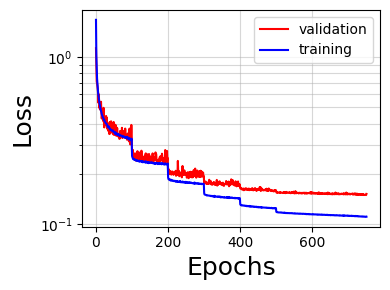

In [26]:
fig = plt.figure(figsize=(5,3))

detailed = False

if not detailed:
    fig.set_figwidth(4)

    # total loss function
    plt.semilogy(range(val_loss.shape[0]), val_loss[:,0], color='red', label='validation')
    plt.semilogy(range(train_loss.shape[0]), train_loss[:,0], color='blue', label='training')
    plt.legend(fontsize=10)
else:
    # loss values for each component in the loss function
    plt.semilogy(range(val_loss.shape[0]), val_loss[:,1], color='red', label='P_val')
    plt.semilogy(range(train_loss.shape[0]), train_loss[:,1], color='red', linestyle='--', label='P_tr')
    plt.semilogy(range(val_loss.shape[0]), val_loss[:,2], color='blue', label='SW_val')
    plt.semilogy(range(train_loss.shape[0]), train_loss[:,2], color='blue', linestyle='--', label='SW_tr')
    plt.semilogy(range(val_loss.shape[0]), val_loss[:,3], color='green', label='dP_val')
    plt.semilogy(range(train_loss.shape[0]), train_loss[:,3], color='green', linestyle='--', label='dP_tr')
    plt.semilogy(range(val_loss.shape[0]), val_loss[:,4], color='black', label='dSW_val')
    plt.semilogy(range(train_loss.shape[0]), train_loss[:,4], color='black', linestyle='--', label='dSW_tr')
    plt.legend(fontsize=10, loc=(1.01,0))

plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)

plt.grid(alpha=0.5, which='both')
plt.tight_layout()
# plt.savefig(f"./loss_2ph.pdf", dpi=200)
plt.show()

In [21]:
# testing predicitons

ts_preds = torch.empty_like(test_u.squeeze())
ts_errors = torch.empty_like(test_u.squeeze())

model.eval()

for i in range(test_u.shape[0]):
    
    ts_predictions = model(test_a[i:i+1,...,:input_channels].to(device)).cpu().detach()
    
    ts_error = 100*torch.abs( (ts_predictions - test_u[i,...]) / test_u[i,...] )

    ts_preds[i] = ts_predictions
    ts_errors[i] = ts_error
    
ts_preds.shape, ts_errors.shape

(torch.Size([200, 40, 40, 40, 2]), torch.Size([200, 40, 40, 40, 2]))

In [22]:
# this block generates a dicitonarry where you can find how many wells there are in each sample of the testing set.
# this is only useful if the user desire to display result for samples with specific number of wells.

N = {}

for i in range(test_a.shape[0]):

    nw = test_a[i,...,1,3].nonzero().shape[0]

    if nw not in N.keys():
        N[ nw ] = []
        N[ nw ].append(i)
    else:
        N[ nw ].append(i)

N.keys()

dict_keys([11, 7, 6, 3, 10, 4, 9, 5, 8])

[53, 191, 91] [14, 34, 15]
done


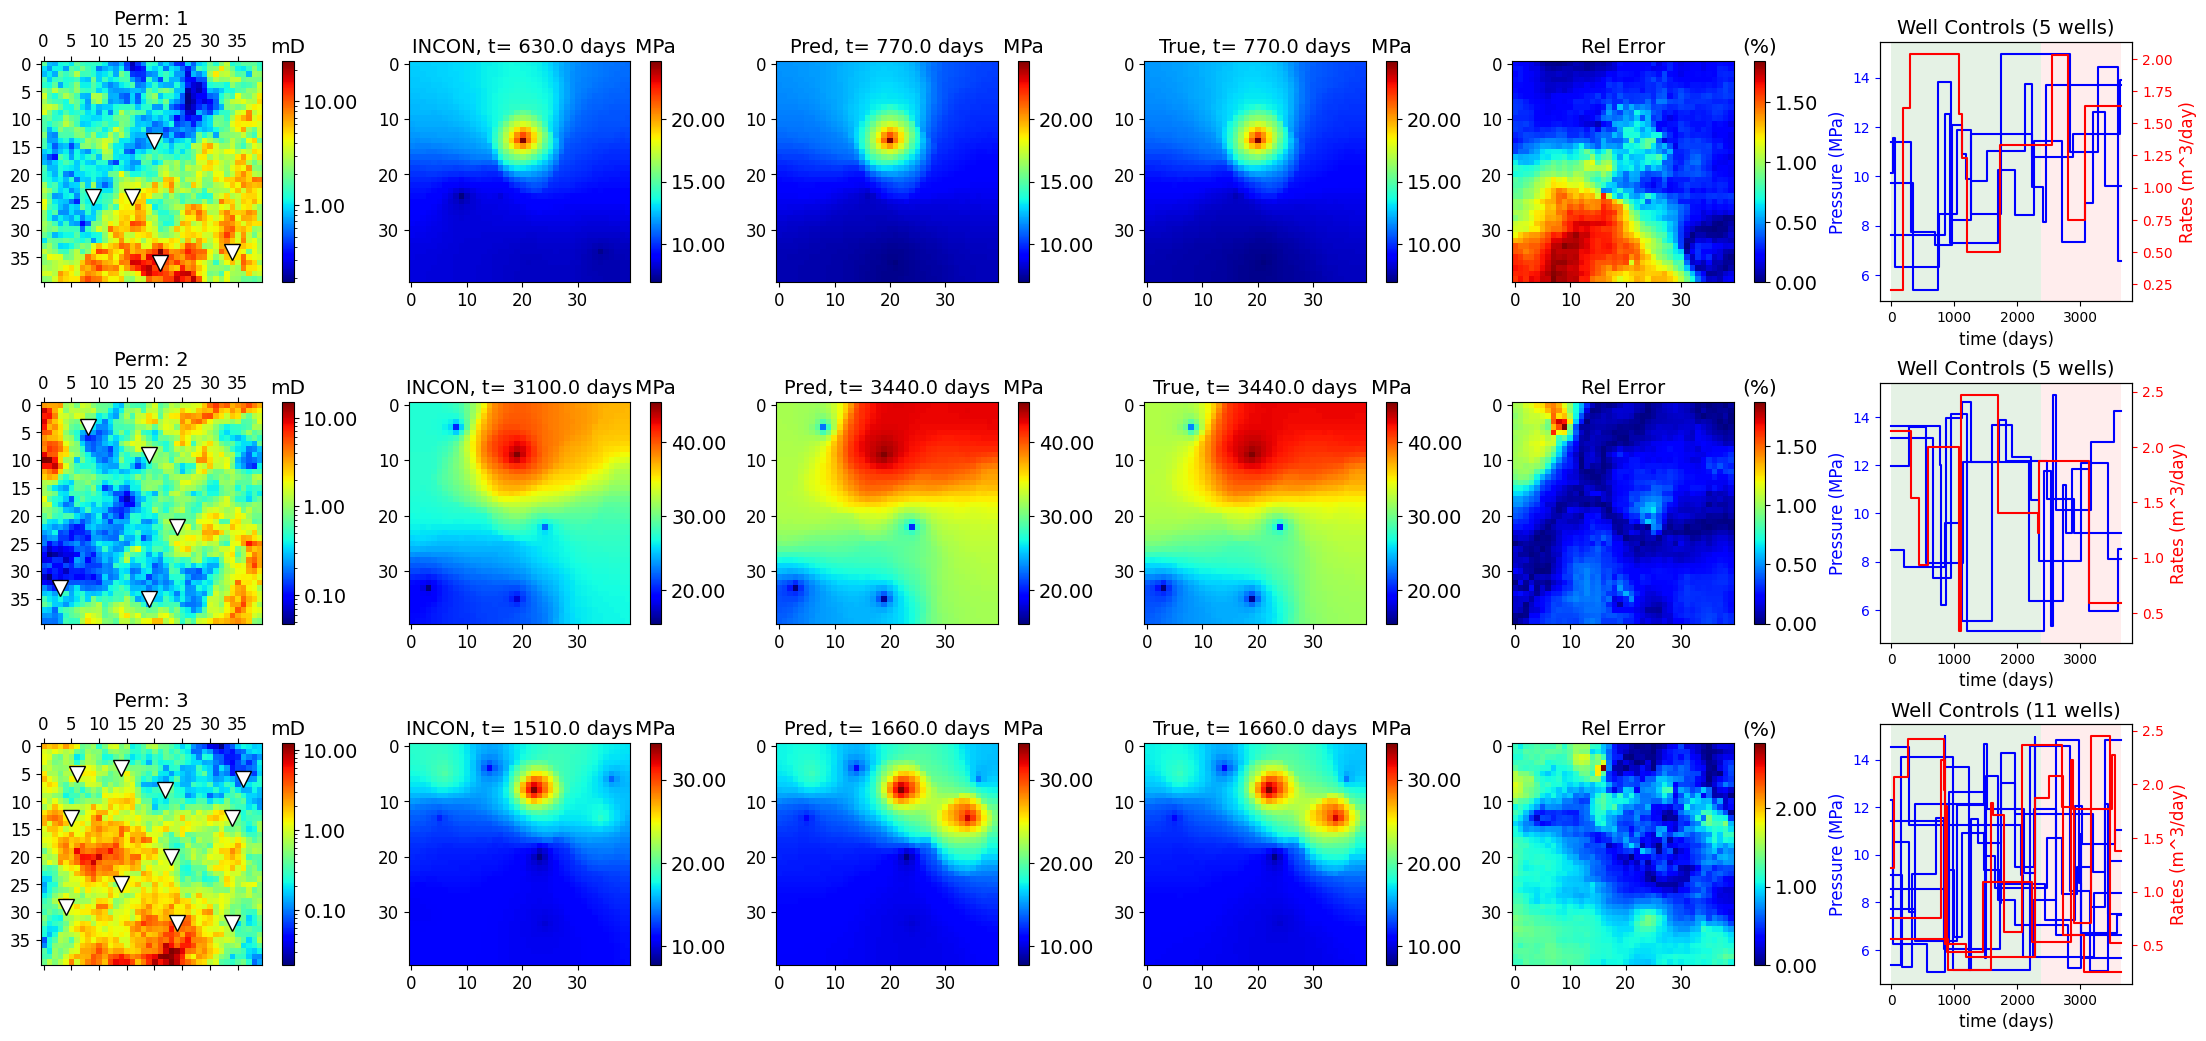

In [22]:
n_samples = 3

fig, ax = plt.subplots(n_samples, 6, figsize=(22,3.5*n_samples))

# use to generate random samples and random output times
n = np.random.randint(0, ts_preds.shape[0], n_samples).tolist()
t = np.random.randint(1, test_a.shape[-2], n_samples).tolist()

# # uncomment of you desire specific number of wells, e.g. [3,9,11] wells
# n = [random.choice(N[3]), random.choice(N[9]), random.choice(N[11])]

## use if you want to display predictions at the latest timestep (nt=40)
# t = [-1,-1,-1]

print(n, t)

# output channel: pressure or saturation
c = 0

labels = ['mD', 'MPa', 'MPa', 'MPa', '(%)', 'MPa']

for k in range(len(n)):
    
    Nprods = test_a[n[k],...,1,1].nonzero().shape[0]
    Ninjs = test_a[n[k],...,1,2].nonzero().shape[0]
    
    pred_numpy = ts_preds[n[k],...,t[k],c]*pmax/kPa
    true_numpy = test_u[n[k],...,t[k],c]*pmax/kPa
    incon = test_a[n[k],...,t[k],4]*pmax/kPa
    
    perm_numpy = test_a[n[k],...,t[k],c]
    perm_numpy = 10**( perm_numpy * ( np.log10(kmax/kmin) ) + np.log10(kmin)) / mD
    rel_error = ts_errors[n[k],...,t[k],c]
    
    im01 = ax[k,0].imshow(perm_numpy, cmap='jet', norm=colors.LogNorm(), origin='upper')
    im02 = ax[k,1].imshow(incon, cmap='jet')
    im03 = ax[k,2].imshow(pred_numpy, cmap='jet')
    im04 = ax[k,3].imshow(true_numpy, cmap='jet')
    im05 = ax[k,4].imshow(rel_error, cmap='jet', vmin=0.0)

    ax[k,0].spy( test_a[n[k],:,:,0,3], marker='v',
                 color="white",markersize=12, markeredgecolor='k' )
    
    prods_sorted_indexes = np.sort( np.ravel_multi_index(test_a.numpy()[n[k],:,:,0,1].nonzero(), (nx,ny), order='F') )
    prods_indexes = np.unravel_index(prods_sorted_indexes, (nx,ny), order='F')
    
    injs_sorted_indexes = np.sort( np.ravel_multi_index(test_a.numpy()[n[k],:,:,0,2].nonzero(), (nx,ny), order='F') )
    injs_indexes = np.unravel_index(injs_sorted_indexes, (nx,ny), order='F')
    
    twf = test_a_original[n[k],0,0,:,-1]
    
    for p in range(Nprods):
        prod_pwf = test_a_original[n[k], prods_indexes[0][p], prods_indexes[1][p], :, 1]
        ax[k,5].step(twf, prod_pwf/1000, '-', where='post', color='blue', label='prod_1')
    
    ax2 = ax[k,5].twinx()
    
    for i in range(Ninjs):
        inj_rates = test_a_original[n[k], injs_indexes[0][i], injs_indexes[1][i], :, 2]
        
        ax2.step(twf, inj_rates, '-', where='post', color='red', label='inj_1')


    ax[k,5].set_xlabel("time (days)", fontsize=12)
    ax[k,5].set_ylabel("Pressure (MPa)", fontsize=12, color='blue')
    ax[k,5].tick_params(axis='y', colors='blue')
    ax2.set_ylabel(r"Rates (m^3/day)", fontsize=12, color='red')
    ax2.tick_params(axis='y', colors='red')
    
    ax[k,0].tick_params(axis='both', which='major', labelsize=12)
    ax[k,1].tick_params(axis='both', which='major', labelsize=12)
    ax[k,2].tick_params(axis='both', which='major', labelsize=12)
    ax[k,3].tick_params(axis='both', which='major', labelsize=12)
    ax[k,4].tick_params(axis='both', which='major', labelsize=12)

# ------------------------------------------------------------------------------------------------------
    im = [im01, im02, im03, im04, im05]
    
    divider = make_axes_locatable(ax[k,0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[0], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[0], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,1])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[1], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[1], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,2])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[1], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[2], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,3])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[1], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[3], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,4])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[4], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[4], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    ax[k,0].set_title(f"Perm: {k+1}", fontsize=14)
    ax[k,1].set_title(f"INCON, t= {test_a[n[k],0,0,0,-1]*max_time:.1f} days", fontsize=14)
    ax[k,2].set_title(f"Pred, t= {test_a[n[k],0,0,:,-1][t[k]]*max_time:.1f} days", fontsize=14)
    ax[k,3].set_title(f"True, t= {test_a[n[k],0,0,:,-1][t[k]]*max_time:.1f} days", fontsize=14)
    ax[k,4].set_title("Rel Error", fontsize=14)
    ax[k,5].set_title(f"Well Controls ({Nprods+Ninjs} wells)", fontsize=14)
    
    ax[k,5].axvspan(0.0, 2380, facecolor='green', alpha=0.1)
    ax[k,5].axvspan(2380, 3650, facecolor='red', alpha=0.07)
    
# -------------------------------------------------------------------
plt.tight_layout(pad=0.8)
# plt.savefig(f"./p_pred_{today}.pdf", dpi=200, bbox_inches='tight')
print("done")
plt.show()

done


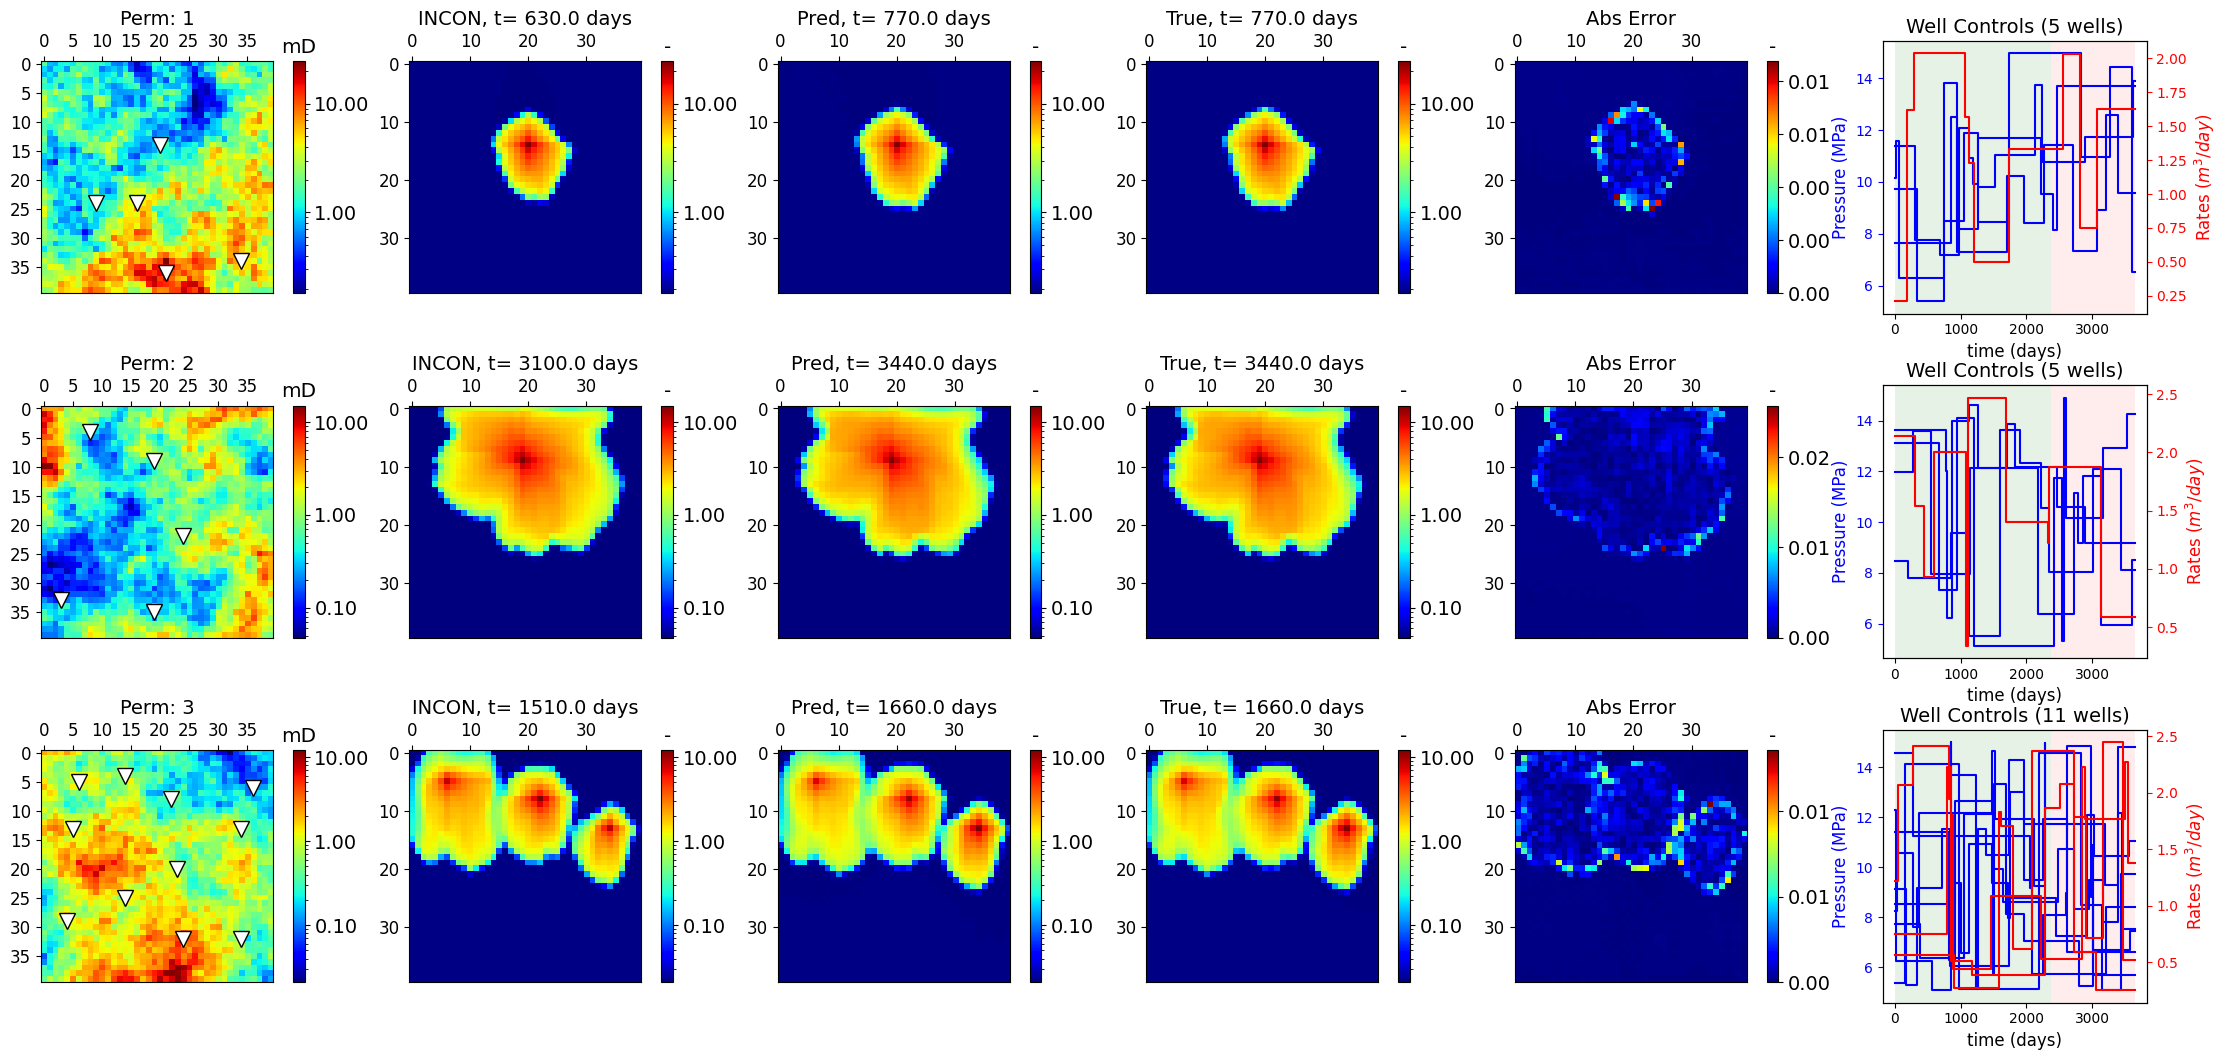

In [23]:
fig, ax = plt.subplots(n_samples, 6, figsize=(22,3.5*n_samples))

# output channel: saturation
c = 1

labels = ['mD', '-', '-', '-', '-', 'MPa']

for k in range(len(n)):
    
    Nprods = test_a[n[k],...,1,1].nonzero().shape[0]
    Ninjs = test_a[n[k],...,1,2].nonzero().shape[0]
    
    pred_numpy = ts_preds[n[k],...,t[k],c]
    true_numpy = test_u[n[k],...,t[k],c]
    incon = test_a[n[k],...,t[k],5]
    
    perm_numpy = test_a[n[k],...,t[k],0]
    perm_numpy = 10**( perm_numpy * ( np.log10(kmax) - np.log10(kmin) ) + np.log10(kmin) ) / mD

    abs_error = test_u[n[k],...,t[k],c] * ts_errors[n[k],...,t[k],c] / 100
    
    im01 = ax[k,0].imshow(perm_numpy, cmap='jet', norm=colors.LogNorm(), origin='upper')
    im02 = ax[k,1].imshow(incon, cmap='jet', vmin=0.2)
    im03 = ax[k,2].imshow(pred_numpy, cmap='jet', vmin=0.2)
    im04 = ax[k,3].imshow(true_numpy, cmap='jet', vmin=0.2)
    im05 = ax[k,4].imshow(abs_error, cmap='jet', vmin=0.0)

    ax[k,0].spy( test_a[n[k],:,:,0,3], marker='v',
                 color="white",markersize=12, markeredgecolor='k' )
    
    prods_sorted_indexes = np.sort( np.ravel_multi_index(test_a.numpy()[n[k],:,:,0,1].nonzero(), (nx,ny), order='F') )
    prods_indexes = np.unravel_index( prods_sorted_indexes, (nx,ny), order='F' )
    
    injs_sorted_indexes = np.sort( np.ravel_multi_index(test_a.numpy()[n[k],:,:,0,2].nonzero(), (nx,ny), order='F') )
    injs_indexes = np.unravel_index( injs_sorted_indexes, (nx,ny), order='F' )
    
    twf = test_a_original[n[k],0,0,:,-1]
    
    for p in range(Nprods):
        prod_pwf = test_a_original[n[k], prods_indexes[0][p], prods_indexes[1][p], :, 1]
        ax[k,5].step(twf, prod_pwf/1000, '-', where='post', label='prod_1', color='blue')
    
    ax2 = ax[k,5].twinx()
    
    for i in range(Ninjs):
        inj_rates = test_a_original[n[k], injs_indexes[0][i], injs_indexes[1][i], :, 2]
        
        ax2.step(twf, inj_rates, '-', where='post', label='inj_1', color='red')

    ax[k,5].set_xlabel("time (days)", fontsize=12)
    ax[k,5].set_ylabel("Pressure (MPa)", fontsize=12, color='blue')
    ax[k,5].tick_params(axis='y', colors='blue')
    ax2.set_ylabel(r"Rates $(m^3/day)$", fontsize=12, color='red')
    ax2.tick_params(axis='y', colors='red')
    
    ax[k,0].tick_params(axis='both', which='major', labelsize=12)
    ax[k,1].tick_params(axis='both', which='major', labelsize=12)
    ax[k,2].tick_params(axis='both', which='major', labelsize=12)
    ax[k,3].tick_params(axis='both', which='major', labelsize=12)
    ax[k,4].tick_params(axis='both', which='major', labelsize=12)

# ------------------------------------------------------------------------------------------------------
    im = [im01, im02, im03, im04, im05]
    
    divider = make_axes_locatable(ax[k,0])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[0], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[0], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,1])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[0], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[1], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,2])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[0], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[2], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,3])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[0], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[3], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')
    
    divider = make_axes_locatable(ax[k,4])
    cax = divider.append_axes('right', size='5%', pad=0.2)
    s = fig.colorbar(im[4], cax=cax, format='%.2f')
    s.ax.set_title(label=labels[4], size='x-large')
    s.ax.tick_params(labelsize=14, which='major')

    ax[k,0].xaxis.tick_top()
    ax[k,0].xaxis.set_label_position('top')
    ax[k,1].xaxis.tick_top()
    ax[k,1].xaxis.set_label_position('top')
    ax[k,2].xaxis.tick_top()
    ax[k,2].xaxis.set_label_position('top')
    ax[k,3].xaxis.tick_top()
    ax[k,3].xaxis.set_label_position('top')
    ax[k,4].xaxis.tick_top()
    ax[k,4].xaxis.set_label_position('top')
        
    ax[k,0].set_title(f"Perm: {k+1}", fontsize=14)
    ax[k,1].set_title(f"INCON, t= {test_a[n[k],0,0,0,-1]*max_time:.1f} days", fontsize=14)
    ax[k,2].set_title(f"Pred, t= {test_a[n[k],0,0,:,-1][t[k]]*max_time:.1f} days", fontsize=14)
    ax[k,3].set_title(f"True, t= {test_a[n[k],0,0,:,-1][t[k]]*max_time:.1f} days", fontsize=14)
    ax[k,4].set_title("Abs Error", fontsize=14)
    ax[k,5].set_title(f"Well Controls ({Nprods+Ninjs} wells)", fontsize=14)
    
    ax[k,5].axvspan(0.0, 2380, facecolor='green', alpha=0.1)
    ax[k,5].axvspan(2380, 3650, facecolor='red', alpha=0.07)
    
# -------------------------------------------------------------------
plt.tight_layout(pad=0.07)
# plt.savefig(f"./sw_pred_{today}.pdf", dpi=200, bbox_inches='tight')
print("done")
plt.show()